In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from skbio.tree import TreeNode
from itertools import combinations
from scipy.stats import mannwhitneyu
from skbio.stats.distance import mantel
from glob import glob
from os.path import join, basename
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from ggmap.snippets import *
from ggmap.analyses import *
from ggmap.correlations import *
from ggmap.workflow import *
import calour as ca
ca.set_log_level(40)
import io

import requests
import json
import fetch
from ggmap.tree import *
from ggmap.utils import *
from ggmap.readwrite import *

from scipy.spatial import distance
from scipy.cluster import hierarchy

ggmap is custome code from Stefan Janssen, download at https://github.com/sjanssen2/ggmap
Reading settings file '/home/jansses/.ggmaprc'
ggmap is custome code from Stefan Janssen, download at https://github.com/sjanssen2/ggmap
Reading settings file '/home/jansses/.ggmaprc'
/home/jansses/miniconda3/envs/notebookServer/lib/python3.6/site-packages/docrep-0.2.5-py3.6.egg/docrep/__init__.py:341: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  s = dedents('\n' + '\n'.join(lines[first:]))
/home/jansses/miniconda3/envs/notebookServer/lib/python3.6/site-packages/docrep-0.2.5-py3.6.egg/docrep/__init__.py:341: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  s = dedents('\n' + '\n'.join(lines[first:]))
/home/jansses/miniconda3/envs/notebookServer/lib/python3.6/site-packages/docrep-0.2.5-py3.6.egg/docrep/__ini

In [2]:
def _savefig(fig, name):
    os.makedirs('Figures_generated/SVG', exist_ok=True)
    os.makedirs('Figures_generated/PNG', exist_ok=True)
    
    fig.savefig('Figures_generated/SVG/%s.svg' % name, bbox_inches='tight')
    fig.savefig('Figures_generated/PNG/%s.png' % name, bbox_inches='tight')

In [3]:
meta = pd.read_excel("Incoming/Serum samples for bacterial metabolites analysis - sent on 13-01-2020.xlsx", sheet_name="Murine serum samples").rename(columns={'tube_number': 'sample_name'})
meta['sample_name'] = meta['sample_name'].astype(str)
meta = meta.set_index('sample_name')

x = pd.read_excel('Incoming/200225__Data_20-0005.xlsx', sheet_name="01.AllData").rename(columns={'Sample.label.on.tube': 'sample_name'})
x['sample_name'] = x['sample_name'].astype(str)
data = x[['sample_name', "Compound", "ISTD", "Resp", "ISTD.Resp", "Resp.Ratio", "UserAnno.Peak", "MI.Peak", "MZ", "MZ.Ex.Left", "MZ.Ex.Right", "MZ.Ex.Units", "RT.Compound", "RT.Peak", "MS.Replicates", "data.source", "ISTD.Resp.Ratio", "Acq.Method.Condensed", "MS.project", "Report.Name", "data.dir", "relativeResponse", "IQR_1.5_outlier"]].set_index(['sample_name', 'Compound'])
counts_metabolome = pd.pivot_table(data=data, columns='sample_name', index="Compound", values="relativeResponse").fillna(0)

In [4]:
res_alpha = alpha_diversity(counts_metabolome, metrics=['shannon'], dry=False, wait=False, rarefaction_depth=None)
res_alpha['results'].index = list(map(str, res_alpha['results'].index))

res_beta= beta_diversity(counts_metabolome, metrics=['bray_curtis', 'jaccard'], dry=False, wait=False)
if res_beta['results'] is not None:
    res_emperor = emperor(meta, res_beta['results'], fp_results="./Emperor/", dry=False, wait=False, infix='_metabolome')

Using existing results from '.anacache/863d46e0d0daa2981a9ec1cbeaf5d11d.adiv'. 
Using existing results from '.anacache/8a60d661a77d7f0c480e7eb4d518879b.bdiv'. 
Working directory is '/home/jansses/TMP/ana_emperor_efnpnp0a'. Now wait until 5501370.hpc-batch14 job finishes.


In [7]:
res_corr = correlation_diversity_metacolumns(meta, ["genotype", "antibiotics_treatment_start_timestamp", "facility", "diseased", "cage", "sex"], res_alpha['results'], res_beta['results'],
                                             dry=False, wait=False)
if res_corr['results'] is not None:
    cols_significant = [c for c,pval in res_corr['results'].groupby('column')['p-value'].min().sort_values().iteritems() if pval <= 0.05]
    print("Follwing metadata columns significantly correlate with metabolome data:\n\n%s" % '\n'.join(cols_significant))

found matching working dir "/home/jansses/TMP/ana_corr-divmeta_i1cjka31"


Follwing metadata columns significantly correlate with metabolome data:

antibiotics_treatment_start_timestamp
cage
diseased
genotype


 Was removed.


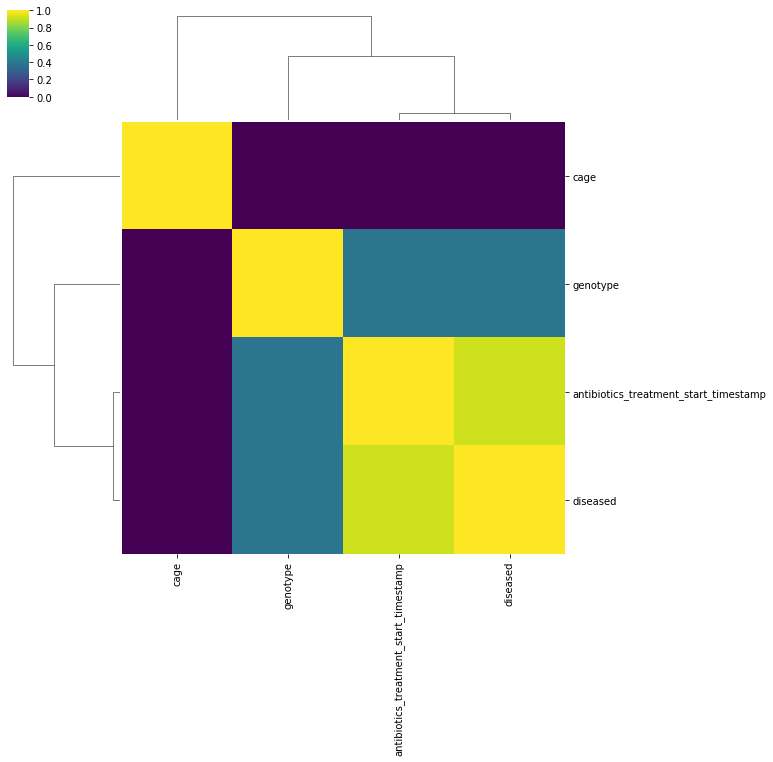

In [8]:
fields_categorials = ["genotype", "antibiotics_treatment_start_timestamp", "diseased", "cage"]
fields_intervals = []
fields_ordinals = {}
res_corr_meta = correlate_metadata(meta.loc[:, cols_significant], fields_categorials, fields_ordinals, fields_intervals)

Working directory is '/home/jansses/TMP/ana_fRDAalpha_6s25g60j'. Now wait until 5501374.hpc-batch14 job finishes.
Working directory is '/home/jansses/TMP/ana_fRDAbeta__41f_kq3'. /home/jansses/miniconda3/envs/notebookServer/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.005294942796765846 and the largest is 0.16923986738185393.
  RuntimeWarning
Now wait until 5501375.hpc-batch14 job finishes.


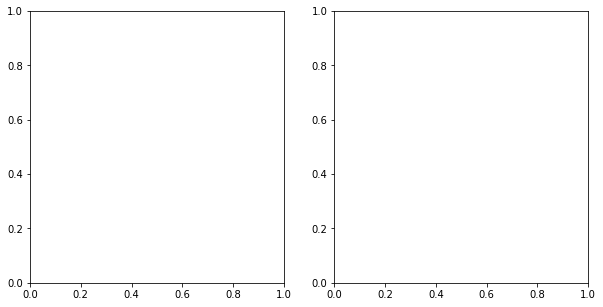

In [9]:
fields = ["diseased", "genotype"]
max_rows = max(len(res_alpha['results'].keys()), len(res_beta['results'].keys()))
fig, axes = plt.subplots(1, 2, figsize=(5*2, 5*1))
metric = 'shannon'
_ = redundancy_analysis_alpha(meta, res_alpha['results'][metric],
                          categorials=fields, 
                          ax=axes[0], title=metric,
                          dry=False, wait=False)
metric = 'bray_curtis'
_ = redundancy_analysis_beta(meta, res_beta['results'][metric], metric,
                         categorials=fields, 
                         ax=axes[1], title=metric,
                         dry=False, wait=False)

## Specific analyses

In [10]:
fp_diffabund = 'Workdir/metabolome_diffabund.biom'
fp_meta = 'Workdir/metabolome_diffabund_meta.tsv'

pandas2biom(fp_diffabund, counts_metabolome)
meta.to_csv(fp_meta, sep="\t", index=True)

e = ca.read_amplicon(fp_diffabund, fp_meta, min_reads=0, normalize=10000)

/home/jansses/miniconda3/envs/notebookServer/src/calour/calour/io.py:228: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  metadata = pd.read_table(f, **kwargs)


### Non-diseased animals: difference WT vs. Pax5+/-

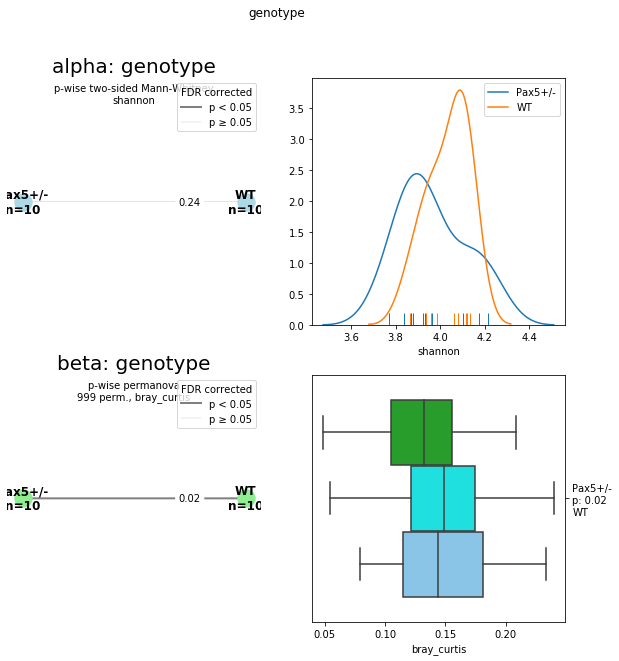

In [11]:
p = plotNetworks("genotype", meta[meta['diseased'] == 'no'], res_alpha['results'], {k: v for k,v in res_beta['results'].items() if k == 'bray_curtis'}, minnumalpha=5, name='genotype')
_savefig(p, 'network_genotype')

/home/jansses/miniconda3/envs/notebookServer/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


'genotype'  (n=30)
     5 taxa different between 'Pax5+/-' (n=10) vs. 'WT' (n=10)



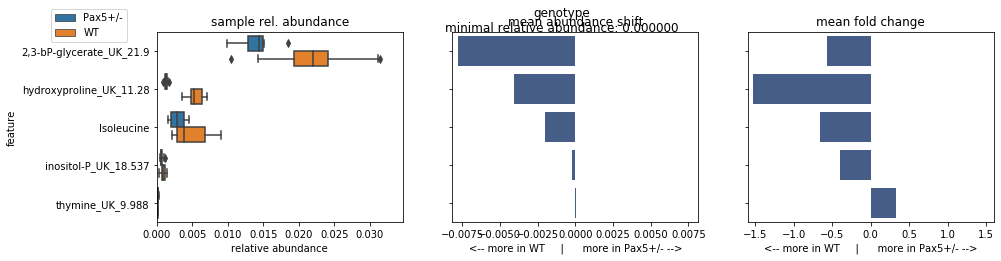

In [12]:
res_dsFDR_genotype = find_diff_taxa(e, meta[meta['diseased'] == 'no'], ['genotype'])
p = plot_diff_taxa(counts_metabolome, meta[meta['diseased'] == 'no']['genotype'], res_dsFDR_genotype, min_mean_abundance=0.0)
_savefig(p[0], 'diffabund_genotype')

### Pax5+/- animals: sick vs. healthy

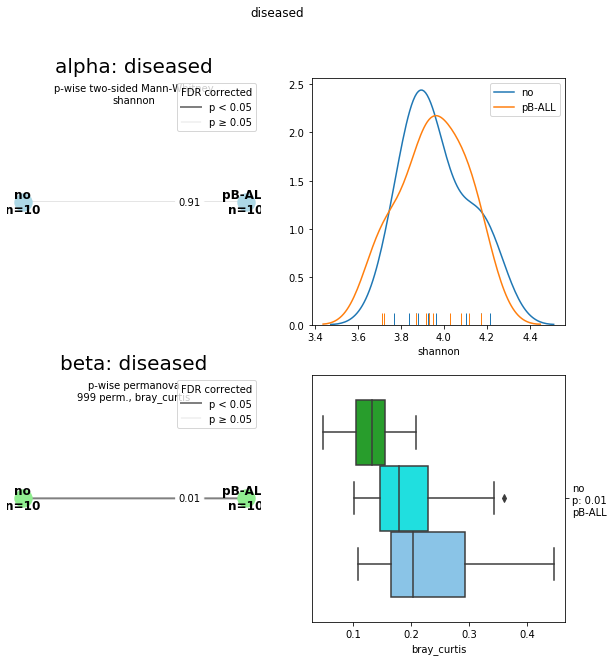

In [13]:
p = plotNetworks("diseased", meta[meta['genotype'] == 'Pax5+/-'], res_alpha['results'], {k: v for k,v in res_beta['results'].items() if k == 'bray_curtis'}, minnumalpha=5, name='diseased')
_savefig(p, 'network_diseased')

/home/jansses/miniconda3/envs/notebookServer/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


'diseased'  (n=30)
    13 taxa different between 'no' (n=10) vs. 'pB-ALL' (n=10)



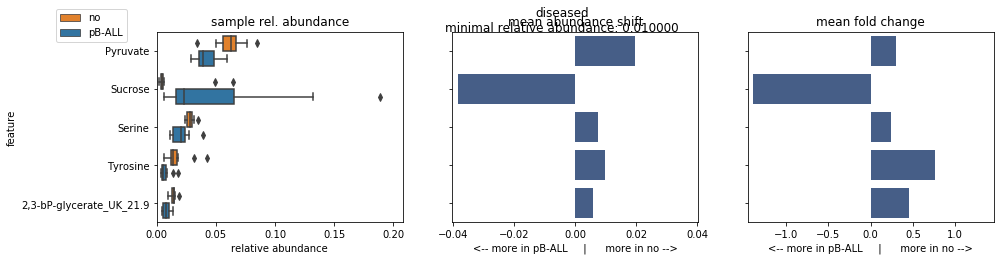

In [14]:
res_dsFDR_diseased = find_diff_taxa(e, meta[meta['genotype'] == 'Pax5+/-'], ['diseased'])
p = plot_diff_taxa(counts_metabolome, meta[meta['genotype'] == 'Pax5+/-']['diseased'], res_dsFDR_diseased, min_mean_abundance=0.01)
_savefig(p[0], 'diffabund_diseased')